## Model Selection

This notebook should include preliminary and baseline modeling.
- Try as many different models as possible.
- Don't worry about hyperparameter tuning or cross validation here.
- Ideas include:
    - linear regression
    - support vector machines
    - random forest
    - xgboost

In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 919.0 kB/s eta 0:02:16
   ---------------------------------------- 0.7/124.9 MB 5.7 MB/s eta 0:00:22
    --------------------------------------- 2.7/124.9 MB 15.5 MB/s eta 0:00:08
   -- ------------------------------------- 6.7/124.9 MB 30.8 MB/s eta 0:00:04
   --- ------------------------------------ 11.2/124.9 MB 81.8 MB/s eta 0:00:02
   ---- ----------------------------------- 13.7/124.9 MB 81.8 MB/s eta 0:00:02
   ----- ---------------------------------- 17.8/124.9 MB 81.8 MB/s eta 0:00:02
   ------- -------------------------------- 22.2/124.9 MB 93.0 MB/s eta 0:00:02
   -------- ------------------------------- 26.2/124.9 MB 93.9 MB/s eta 0:00:02
   --------- ------------------------------ 30.4/124.9 MB 93.9 MB/s eta 0:00:02
   ---------- ----------------------------- 33.8/124.9 MB 81.8

In [44]:
# import models and fit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
# load data
train_df = pd.read_csv('../preprocessed/train_df.csv')
test_df = pd.read_csv('../preprocessed/test_df.csv')

X_train = train_df.drop(columns=['description.sold_price'])
y_train = train_df['description.sold_price']
X_test = test_df.drop(columns=['description.sold_price'])
y_test = test_df['description.sold_price']

numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
boolean_features = X_train.select_dtypes(include=['bool']).columns

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   list_price                   5352 non-null   float64
 1   price_reduced_amount         5352 non-null   float64
 2   description.year_built       5352 non-null   int64  
 3   description.baths_3qtr       5352 non-null   float64
 4   description.sold_price       5352 non-null   float64
 5   description.baths_full       5352 non-null   float64
 6   description.baths_half       5352 non-null   float64
 7   description.lot_sqft         5352 non-null   float64
 8   description.sqft             5352 non-null   float64
 9   description.baths            5352 non-null   float64
 10  description.sub_type         5352 non-null   object 
 11  description.garage           5352 non-null   float64
 12  description.stories          5352 non-null   float64
 13  description.beds  

In [45]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# one -hot encode categorical features
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_features]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_features]).toarray()

# recombine numerical and encoded categorical data
X_train_final = np.hstack([X_train[numerical_features].values, X_train_encoded])
X_test_final = np.hstack([X_test[numerical_features].values, X_test_encoded])

In [46]:
# training linear regression model
model = LinearRegression()
model.fit(X_train_final, y_train)

# test set prediciton
y_pred = model.predict(X_test_final)

# model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Linear Regression Performance Metrics:
Mean Absolute Error (MAE): 69175.00
Mean Squared Error (MSE): 20359357639.29
Root Mean Squared Error (RMSE): 142686.22
R-squared (R²): 0.91


In [47]:
# random forest regressor
rf_model = RandomForestRegressor()  # You can tune n_estimators and other hyperparameters
rf_model.fit(X_train_final, y_train)

# predict on the test set
y_pred_rf = rf_model.predict(X_test_final)

# evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-squared (R²): {r2_rf:.2f}")

Random Forest Performance Metrics:
Mean Absolute Error (MAE): 12227.52
Mean Squared Error (MSE): 62823024120.40
Root Mean Squared Error (RMSE): 250645.22
R-squared (R²): 0.73


In [ ]:
# svm
svr_model = SVR(kernel='poly')  
svr_model.fit(X_train_final, y_train)

# predict on the test set
y_pred_svr = svr_model.predict(X_test_final)

# evaluate the svr model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print("Support Vector Regressor Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr:.2f}")
print(f"Mean Squared Error (MSE): {mse_svr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_svr:.2f}")
print(f"R-squared (R²): {r2_svr:.2f}")

Support Vector Regressor Performance Metrics:
Mean Absolute Error (MAE): 218082.36
Mean Squared Error (MSE): 242249386771.44
Root Mean Squared Error (RMSE): 492188.37
R-squared (R²): -0.03


In [ ]:
#xgboost
xgb_model = xgb.XGBRegressor()  
xgb_model.fit(X_train_final, y_train)

# predict on the test set
y_pred_xgb = xgb_model.predict(X_test_final)

# evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R²): {r2_xgb:.2f}")

XGBoost Performance Metrics:
Mean Absolute Error (MAE): 15172.27
Mean Squared Error (MSE): 63484761165.69
Root Mean Squared Error (RMSE): 251961.82
R-squared (R²): 0.73


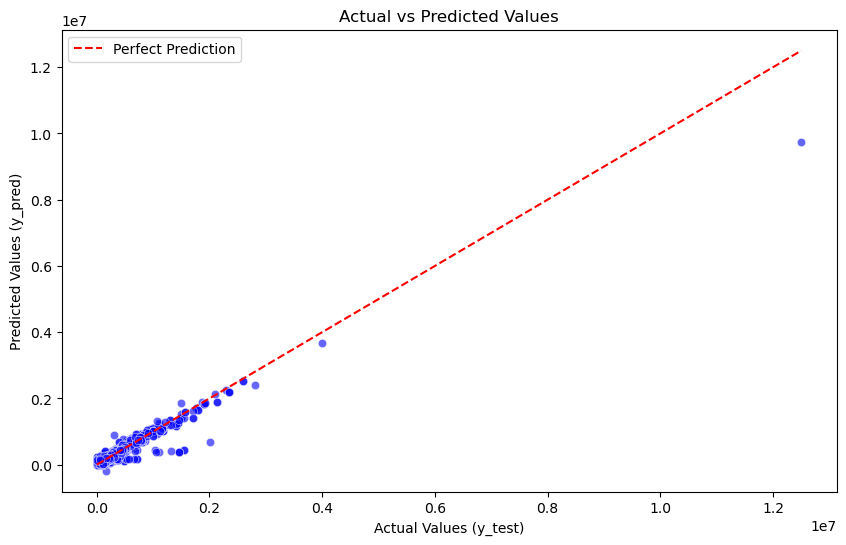

In [ ]:
# visualize y_test, y_preds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--', label='Perfect Prediction') # Diagonal line for reference
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

618329083728.008
170574.61621332404
0.07106832932860896


617839820230.9951
170387.02795746463
0.07180336245197205


Consider what metrics you want to use to evaluate success.
- If you think about mean squared error, can we actually relate to the amount of error?
- Try root mean squared error so that error is closer to the original units (dollars)
- What does RMSE do to outliers?
- Is mean absolute error a good metric for this problem?
- What about R^2? Adjusted R^2?
- Briefly describe your reasons for picking the metrics you use

In [6]:
# gather evaluation metrics and compare results

## Feature Selection - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its recommended you complete it if you have time!**

Even with all the preprocessing we did in Notebook 1, you probably still have a lot of features. Are they all important for prediction?

Investigate some feature selection algorithms (Lasso, RFE, Forward/Backward Selection)
- Perform feature selection to get a reduced subset of your original features
- Refit your models with this reduced dimensionality - how does performance change on your chosen metrics?
- Based on this, should you include feature selection in your final pipeline? Explain

Remember, feature selection often doesn't directly improve performance, but if performance remains the same, a simpler model is often preferrable. 



Best parameters found:  {'fs__k': 180, 'model__fit_intercept': True}
Best cross-validation score:  0.8963785738281007
Mean Squared Error: 546320331254.04694
Mean Absolute Error: 65913.91139240506
R^2 Score: 0.17924892846087248


/opt/anaconda3/envs/LHL/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/LHL/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/LHL/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/LHL/lib/python3.11/site-packages/sklearn/pipeline.py", line 4

Best parameters found:  {'fs__k': 90, 'model__C': True}
Best cross-validation score:  -0.04602343008841343
Mean Squared Error: 676841446287.0402
Mean Absolute Error: 236513.0231623813
R^2 Score: -0.016836296439893816


Best parameters found:  {'fs__k': 50, 'model__max_depth': 40, 'model__n_estimators': 100}
Best cross-validation score:  0.46942166975893435
618422074192.981
172616.2936230366
0.0709286273636569


Best parameters found:  {'fs__k': 50, 'model__learning_rate': 0.3, 'model__max_depth': 10, 'model__n_estimators': 100}
Best cross-validation score:  0.47037076064361455
Mean Squared Error: 617434804993.8838
Mean Absolute Error: 170709.48518649943
R^2 Score: 0.07241182724969575
